#                            Capstone Project: Battle of Neighborhoods

## BUSINESS PROBLEM
Before opening a restaurant there are few factors to be considered like the location, the cuisine type, the locality, and the local competition, permits, expenses like construction, salary etc. Few things that can be solved using data science are the location, the cuisine type and in which borough to start. The location is the crux of the business, for the sake of the capstone project, I have selected a US state which is famous for the prestigious Universities located here. Since it is a global hub for students, we can expect people from different countries having various preferences in the cuisine type to be living there. The goal of the project will be to identify a place suitable for the restaurant, the type of restaurant and the cuisine type.

## DATA
1. A csv file containing the zip, zip code name, city, state, county name of Massachusetts can be downloaded from the following link.
    https://www.downloadexcelfiles.com/us_en/download-list-us-zip-codes-massachusetts-state#.XukY8WgzZPY

2. For the venue details we can use the foursquare api
      https://foursquare.com/developers/apps

3. For the latitude and longitude data we use a library name pygeocode,
    * Input: a list of pin code (5 digits)
    * Output: A data frame with the following columns: - postal code, country code, place name, state name, accuracy, county code, latitude and longitude, community name and community code
4. https://www.unitedstateszipcodes.org/
    
After few processing we have a perfect final version of the data frame with postal codes, place name, state name, country code, county code and their respective latitude and longitude 

### Import the necessary library

In [17]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import pgeocode
import matplotlib.pyplot as plt
print('Libraries imported.')

Libraries imported.


### Download the dataset and preprocess them

In [2]:
x=pd.read_csv('US_zip.csv')

In [3]:
x.head()

,zip,Zipcode name,City,State,County Name
0,2351,"ABINGTON, MA",ABINGTON,MA,PLYMOUTH
1,2018,"ACCORD, MA",ACCORD,MA,PLYMOUTH
2,1720,"ACTON, MA",ACTON,MA,MIDDLESEX
3,2743,"ACUSHNET, MA",ACUSHNET,MA,BRISTOL
4,1220,"ADAMS, MA",ADAMS,MA,BERKSHIRE


#### Segragate the ZIP codes

In [4]:
pin=x['zip']
pin.head()


0    2351
1    2018
2    1720
3    2743
4    1220
Name: zip, dtype: object

In [5]:
pin=list(pin)
type(pin[1])
for i in range(len(pin)):
    pin[i]=str(pin[i])
    pin[i]=pin[i].zfill(5)

#### Using the pygeocode library to get the latitude and longitude data

In [7]:
nomi = pgeocode.Nominatim('us')

In [8]:
df=nomi.query_postal_code(pin)

In [9]:
type(df)

pandas.core.frame.DataFrame

In [10]:
df.head()

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,02351,US,Abington,Massachusetts,MA,Plymouth,23.0,NaN,NaN,42.1167,-70.9543,4.0
1,02018,US,Accord,Massachusetts,MA,Plymouth,23.0,NaN,NaN,42.1745,-70.8837,4.0
2,01720,US,Acton,Massachusetts,MA,Middlesex,17.0,NaN,NaN,42.4751,-71.4483,4.0
3,02743,US,Acushnet,Massachusetts,MA,Bristol,5.0,NaN,NaN,41.6997,-70.9087,4.0
4,01220,US,Adams,Massachusetts,MA,Berkshire,3.0,NaN,NaN,42.6223,-73.1172,4.0


#### Final dataframe with only the necessary details

In [11]:
df=df[['postal_code','place_name','state_code','country code','county_code','latitude','longitude']]

In [12]:
df=pd.DataFrame(df)
df.head()

,postal_code,place_name,state_code,country code,county_code,latitude,longitude
0,02351,Abington,MA,US,23.0,42.1167,-70.9543
1,02018,Accord,MA,US,23.0,42.1745,-70.8837
2,01720,Acton,MA,US,17.0,42.4751,-71.4483
3,02743,Acushnet,MA,US,5.0,41.6997,-70.9087
4,01220,Adams,MA,US,3.0,42.6223,-73.1172


#### Plotting the number of neighborhoods

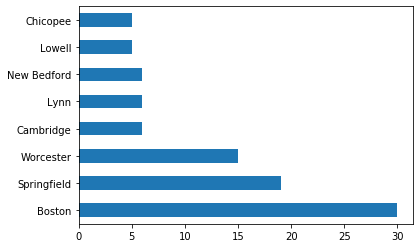

In [29]:
df['place_name'].value_counts()[:8].plot(kind='barh')

#### Selecting Boston city and segreating it's details from the rest

In [287]:
boston_data = df[df['place_name'] == 'Boston'].reset_index(drop=True)

boston_data=boston_data.sort_values(['postal_code'],ascending=True)
boston_data.reset_index(inplace = True, drop = True)
boston_data.shape


(30, 7)

In [288]:

boston_data.head()

,postal_code,place_name,state_code,country code,county_code,latitude,longitude
0,02108,Boston,MA,US,25.0,42.3576,-71.0684
1,02109,Boston,MA,US,25.0,42.3600,-71.0545
2,02110,Boston,MA,US,25.0,42.3576,-71.0514
3,02111,Boston,MA,US,25.0,42.3503,-71.0629
4,02112,Boston,MA,US,25.0,42.3584,-71.0598


#### Loading Neighborhood data to the Boston data frame

In [289]:
y=pd.read_csv('Boston_data.csv')
y=y.sort_values(['postal_code'],ascending=True)
y.reset_index(inplace = True, drop = True)
y.shape

(30, 4)

In [290]:
y.head()

,postal_code,Neighborhood,City,State
0,2108,Beacon Hill,BOSTON,MA
1,2109,North End,BOSTON,MA
2,2110,Financial District|Downtown,BOSTON,MA
3,2111,Chinatown,BOSTON,MA
4,2112,Financial District|Downtown,BOSTON,MA


In [302]:

boston_data.index = y.index
boston_data[['Neighborhood']]=y[['Neighborhood']]

boston_data.head()

,postal_code,place_name,state_code,country code,county_code,latitude,longitude,Neighborhood
0,02108,Boston,MA,US,25.0,42.3576,-71.0684,Beacon Hill
1,02109,Boston,MA,US,25.0,42.3600,-71.0545,North End
2,02110,Boston,MA,US,25.0,42.3576,-71.0514,Financial District|Downtown
3,02111,Boston,MA,US,25.0,42.3503,-71.0629,Chinatown
4,02112,Boston,MA,US,25.0,42.3584,-71.0598,Financial District|Downtown


### Plotting the neighborhoods over the Boston Map

In [292]:
address = 'Boston,MA'

geolocator = Nominatim(user_agent="bs_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


In [293]:
map_boston= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(boston_data['latitude'], boston_data['longitude'], boston_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    
map_boston

## Using the Foursquare API to get the venue details

In [200]:
CLIENT_ID = 'TPD12OWMSRYPTQZLL3NDSWM1ZYOV3G1JJJRAMN2PGGWMIYMK' 
CLIENT_SECRET = 'QUAEYMOQJJBXHCBKB4RUOOKYJ3MLHEXZJH33B3UUCAAWOEIA' 
VERSION = '20200615' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TPD12OWMSRYPTQZLL3NDSWM1ZYOV3G1JJJRAMN2PGGWMIYMK
CLIENT_SECRET:QUAEYMOQJJBXHCBKB4RUOOKYJ3MLHEXZJH33B3UUCAAWOEIA


In [131]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name'],
           ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category',
                  ]
    
    return(nearby_venues)


In [201]:
boston_venues = getNearbyVenues(names=boston_data['Neighborhood'],
                                   latitudes=boston_data['latitude'],
                                   longitudes=boston_data['longitude']
                                  )

In [202]:

print(boston_venues.shape)
boston_venues.head()


(2024, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Beacon Hill,42.3576,-71.0684,Tatte Bakery & Cafe,42.357904,-71.070439,Bakery
1,Beacon Hill,42.3576,-71.0684,Figs,42.357255,-71.070007,Pizza Place
2,Beacon Hill,42.3576,-71.0684,Louisburg Square,42.358636,-71.068903,Plaza
3,Beacon Hill,42.3576,-71.0684,The Paramount,42.357256,-71.070017,Breakfast Spot
4,Beacon Hill,42.3576,-71.0684,Toscano Restaurant,42.357360,-71.070026,Italian Restaurant


### Plotting the most common venue category

In [203]:
boston_venues['Venue Category'].value_counts()[:8]

Coffee Shop            95
Italian Restaurant     80
American Restaurant    79
Sandwich Place         78
Hotel                  67
Historic Site          59
Bakery                 54
Pub                    50
Name: Venue Category, dtype: int64

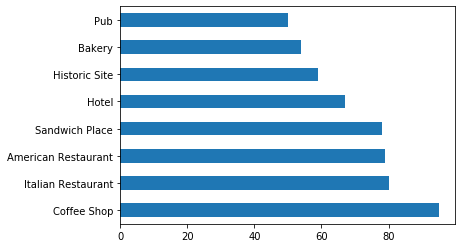

In [204]:
boston_venues['Venue Category'].value_counts()[:8].plot(kind='barh')

In [205]:
boston_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allston,13,13,13,13,13,13
Back Bay,99,99,99,99,99,99
Bank of America,200,200,200,200,200,200
"Bank of America,Fleet Bank Boston",100,100,100,100,100,100
Beacon Hill,36,36,36,36,36,36
Boston City Hall,100,100,100,100,100,100
Cash Management,100,100,100,100,100,100
Chinatown,79,79,79,79,79,79
Downtown,37,37,37,37,37,37


In [206]:
print('There are {} uniques categories.'.format(len(boston_venues['Venue Category'].unique())))


There are 197 uniques categories.


## Analyzing Each Neighborhood

In [208]:
boston_onehot = pd.get_dummies(boston_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
boston_onehot['Neighborhood'] = boston_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]

boston_onehot.head()
boston_onehot.shape
boston_grouped = boston_onehot.groupby('Neighborhood').mean().reset_index()
boston_grouped
boston_grouped.shape
num_top_venues = 5

for hood in boston_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = boston_grouped[boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


----Allston----
                             venue  freq
0                              Pub  0.08
1                          Dog Run  0.08
2  Southern / Soul Food Restaurant  0.08
3                        Gastropub  0.08
4             Ethiopian Restaurant  0.08


----Back Bay----
                venue  freq
0         Coffee Shop  0.06
1                 Spa  0.04
2  Italian Restaurant  0.04
3  Seafood Restaurant  0.04
4      Ice Cream Shop  0.03


----Bank of America----
                 venue  freq
0  American Restaurant  0.06
1          Coffee Shop  0.05
2       Sandwich Place  0.05
3        Historic Site  0.05
4                  Pub  0.04


----Bank of America,Fleet Bank Boston----
                 venue  freq
0  American Restaurant  0.06
1          Coffee Shop  0.05
2       Sandwich Place  0.05
3        Historic Site  0.05
4                  Pub  0.04


----Beacon Hill----
               venue  freq
0        Pizza Place  0.08
1  French Restaurant  0.06
2  Korean Restaurant  0.03
3  

In [233]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boston_grouped['Neighborhood']

for ind in np.arange(boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boston_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Grocery Store,Chinese Restaurant,Gastropub,Latin American Restaurant,Southern / Soul Food Restaurant,Martial Arts Dojo,Dog Run,Sandwich Place,Pub,Video Store
1,Back Bay,Coffee Shop,Seafood Restaurant,Spa,Italian Restaurant,Plaza,Gym,American Restaurant,Bakery,Ice Cream Shop,Mediterranean Restaurant
2,Bank of America,American Restaurant,Sandwich Place,Historic Site,Coffee Shop,Pub,Hotel,Steakhouse,Burger Joint,Shipping Store,Bar
3,"Bank of America,Fleet Bank Boston",American Restaurant,Sandwich Place,Historic Site,Coffee Shop,Pub,Hotel,Steakhouse,Burger Joint,Shipping Store,Bar
4,Beacon Hill,Pizza Place,French Restaurant,Bistro,Restaurant,Korean Restaurant,Lake,Boat or Ferry,Breakfast Spot,Mexican Restaurant,Scenic Lookout


In [234]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Grocery Store,Chinese Restaurant,Gastropub,Latin American Restaurant,Southern / Soul Food Restaurant,Martial Arts Dojo,Dog Run,Sandwich Place,Pub,Video Store
1,Back Bay,Coffee Shop,Seafood Restaurant,Spa,Italian Restaurant,Plaza,Gym,American Restaurant,Bakery,Ice Cream Shop,Mediterranean Restaurant
2,Bank of America,American Restaurant,Sandwich Place,Historic Site,Coffee Shop,Pub,Hotel,Steakhouse,Burger Joint,Shipping Store,Bar
3,"Bank of America,Fleet Bank Boston",American Restaurant,Sandwich Place,Historic Site,Coffee Shop,Pub,Hotel,Steakhouse,Burger Joint,Shipping Store,Bar
4,Beacon Hill,Pizza Place,French Restaurant,Bistro,Restaurant,Korean Restaurant,Lake,Boat or Ferry,Breakfast Spot,Mexican Restaurant,Scenic Lookout
5,Boston City Hall,American Restaurant,Sandwich Place,Historic Site,Coffee Shop,Pub,Hotel,Steakhouse,Burger Joint,Shipping Store,Bar
6,Cash Management,American Restaurant,Sandwich Place,Historic Site,Coffee Shop,Pub,Hotel,Steakhouse,Burger Joint,Shipping Store,Bar
7,Chinatown,Chinese Restaurant,Asian Restaurant,Bakery,Seafood Restaurant,Coffee Shop,Performing Arts Venue,Bubble Tea Shop,Café,Sandwich Place,Spa
8,Downtown,Pizza Place,Italian Restaurant,Food Truck,Hotel Bar,Hotpot Restaurant,Burrito Place,Café,Plaza,Playground,Cycle Studio
9,Financial District|Downtown,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry


## Clustering

In [253]:
kclusters = 5

boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)


len(kmeans.labels_)




18

In [257]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

boston_merged = boston_data

boston_merged = boston_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

boston_merged=boston_merged.drop([25])
boston_merged.reset_index(inplace = True, drop = True)
boston_merged


,postal_code,place_name,state_code,country code,county_code,latitude,longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,02108,Boston,MA,US,25.0,42.3576,-71.0684,Beacon Hill,1.0,Pizza Place,French Restaurant,Bistro,Restaurant,Korean Restaurant,Lake,Boat or Ferry,Breakfast Spot,Mexican Restaurant,Scenic Lookout
1,02109,Boston,MA,US,25.0,42.3600,-71.0545,North End,1.0,Italian Restaurant,Seafood Restaurant,Coffee Shop,Pizza Place,Bakery,Park,Sandwich Place,Hotel,Historic Site,Pub
2,02110,Boston,MA,US,25.0,42.3576,-71.0514,Financial District|Downtown,2.0,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry
3,02111,Boston,MA,US,25.0,42.3503,-71.0629,Chinatown,4.0,Chinese Restaurant,Asian Restaurant,Bakery,Seafood Restaurant,Coffee Shop,Performing Arts Venue,Bubble Tea Shop,Café,Sandwich Place,Spa
4,02112,Boston,MA,US,25.0,42.3584,-71.0598,Financial District|Downtown,2.0,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry
5,02113,Boston,MA,US,25.0,42.3657,-71.0560,North End,1.0,Italian Restaurant,Seafood Restaurant,Coffee Shop,Pizza Place,Bakery,Park,Sandwich Place,Hotel,Historic Site,Pub
6,02114,Boston,MA,US,25.0,42.3611,-71.0682,Downtown,1.0,Pizza Place,Italian Restaurant,Food Truck,Hotel Bar,Hotpot Restaurant,Burrito Place,Café,Plaza,Playground,Cycle Studio
7,02115,Boston,MA,US,25.0,42.3427,-71.0922,West Fens|Kenmore Square,2.0,American Restaurant,Pizza Place,Lounge,Art Museum,Bakery,Mexican Restaurant,Coffee Shop,Thai Restaurant,Japanese Restaurant,Garden
8,02116,Boston,MA,US,25.0,42.3492,-71.0768,Back Bay,1.0,Coffee Shop,Seafood Restaurant,Spa,Italian Restaurant,Plaza,Gym,American Restaurant,Bakery,Ice Cream Shop,Mediterranean Restaurant
9,02117,Boston,MA,US,25.0,42.3585,-71.0580,Financial District|Downtown,2.0,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry


In [262]:
type(boston_merged)
boston_merged['Cluster Labels']=boston_merged['Cluster Labels'].astype(int)

In [263]:
boston_merged.head()

,postal_code,place_name,state_code,country code,county_code,latitude,longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,02108,Boston,MA,US,25.0,42.3576,-71.0684,Beacon Hill,1,Pizza Place,French Restaurant,Bistro,Restaurant,Korean Restaurant,Lake,Boat or Ferry,Breakfast Spot,Mexican Restaurant,Scenic Lookout
1,02109,Boston,MA,US,25.0,42.3600,-71.0545,North End,1,Italian Restaurant,Seafood Restaurant,Coffee Shop,Pizza Place,Bakery,Park,Sandwich Place,Hotel,Historic Site,Pub
2,02110,Boston,MA,US,25.0,42.3576,-71.0514,Financial District|Downtown,2,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry
3,02111,Boston,MA,US,25.0,42.3503,-71.0629,Chinatown,4,Chinese Restaurant,Asian Restaurant,Bakery,Seafood Restaurant,Coffee Shop,Performing Arts Venue,Bubble Tea Shop,Café,Sandwich Place,Spa
4,02112,Boston,MA,US,25.0,42.3584,-71.0598,Financial District|Downtown,2,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry


In [264]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boston_merged['latitude'], boston_merged['longitude'], boston_merged['Neighborhood'], boston_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

### Plotting the Clusters

In [300]:
map_clusters

#### Cluster 1

In [301]:
boston_merged.loc[boston_merged['Cluster Labels'] == 0, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,place_name,latitude,longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Boston,42.3253,-71.1122,Allston,0,Grocery Store,Chinese Restaurant,Gastropub,Latin American Restaurant,Southern / Soul Food Restaurant,Martial Arts Dojo,Dog Run,Sandwich Place,Pub,Video Store


#### Cluster 2

In [295]:
boston_merged.loc[boston_merged['Cluster Labels'] == 1, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,place_name,latitude,longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Boston,42.3576,-71.0684,Beacon Hill,1,Pizza Place,French Restaurant,Bistro,Restaurant,Korean Restaurant,Lake,Boat or Ferry,Breakfast Spot,Mexican Restaurant,Scenic Lookout
1,Boston,42.3600,-71.0545,North End,1,Italian Restaurant,Seafood Restaurant,Coffee Shop,Pizza Place,Bakery,Park,Sandwich Place,Hotel,Historic Site,Pub
5,Boston,42.3657,-71.0560,North End,1,Italian Restaurant,Seafood Restaurant,Coffee Shop,Pizza Place,Bakery,Park,Sandwich Place,Hotel,Historic Site,Pub
6,Boston,42.3611,-71.0682,Downtown,1,Pizza Place,Italian Restaurant,Food Truck,Hotel Bar,Hotpot Restaurant,Burrito Place,Café,Plaza,Playground,Cycle Studio
8,Boston,42.3492,-71.0768,Back Bay,1,Coffee Shop,Seafood Restaurant,Spa,Italian Restaurant,Plaza,Gym,American Restaurant,Bakery,Ice Cream Shop,Mediterranean Restaurant
12,Boston,42.3347,-71.0375,Telegraph Hill|South Boston,1,Italian Restaurant,Pub,Convenience Store,Breakfast Spot,Bowling Alley,Bar,Coffee Shop,New American Restaurant,Dive Bar,Diner
17,Boston,42.3479,-71.0825,Prudential,1,Coffee Shop,Seafood Restaurant,Clothing Store,Hotel,Ice Cream Shop,Bookstore,Italian Restaurant,Women's Store,American Restaurant,Bar
19,Boston,42.3615,-71.0604,Government Center|Downtown,1,Italian Restaurant,Historic Site,Hotel,Bakery,Seafood Restaurant,Coffee Shop,Restaurant,Sandwich Place,Park,Pub
21,Boston,42.3489,-71.0465,West Broadway|South Boston,1,Restaurant,Coffee Shop,Italian Restaurant,Hotel,Asian Restaurant,Bar,American Restaurant,Sandwich Place,Salad Place,Steakhouse


#### Cluster 3

In [296]:
boston_merged.loc[boston_merged['Cluster Labels'] == 2, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,place_name,latitude,longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Boston,42.3576,-71.0514,Financial District|Downtown,2,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry
4,Boston,42.3584,-71.0598,Financial District|Downtown,2,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry
7,Boston,42.3427,-71.0922,West Fens|Kenmore Square,2,American Restaurant,Pizza Place,Lounge,Art Museum,Bakery,Mexican Restaurant,Coffee Shop,Thai Restaurant,Japanese Restaurant,Garden
9,Boston,42.3585,-71.0580,Financial District|Downtown,2,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry
10,Boston,42.3362,-71.0729,South End,2,Donut Shop,Pharmacy,Sushi Restaurant,Deli / Bodega,Convenience Store,Mediterranean Restaurant,Tapas Restaurant,Sandwich Place,Yoga Studio,Flower Shop
11,Boston,42.3389,-70.9196,Financial District|Downtown,2,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry
14,Boston,42.3584,-71.0598,Financial District|Downtown,2,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry
16,Boston,42.3584,-71.0598,Financial District|Downtown,2,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry
18,Boston,42.3584,-71.0598,Boston City Hall,2,American Restaurant,Sandwich Place,Historic Site,Coffee Shop,Pub,Hotel,Steakhouse,Burger Joint,Shipping Store,Bar
20,Boston,42.3503,-71.0539,Financial District|Downtown,2,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Historic Site,Pub,Italian Restaurant,Bar,Donut Shop,Boat or Ferry


#### Cluster 4

In [297]:
boston_merged.loc[boston_merged['Cluster Labels'] == 3, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,place_name,latitude,longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Boston,42.3642,-71.0257,Jeffries Point|East Boston,3,Donut Shop,Harbor / Marina,Coffee Shop,Airport Lounge,American Restaurant,Restaurant,Park,Snack Place,Sports Bar,Bar


#### Cluster 5

In [298]:
boston_merged.loc[boston_merged['Cluster Labels'] == 4, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,place_name,latitude,longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Boston,42.3503,-71.0629,Chinatown,4,Chinese Restaurant,Asian Restaurant,Bakery,Seafood Restaurant,Coffee Shop,Performing Arts Venue,Bubble Tea Shop,Café,Sandwich Place,Spa
